<h1> JuliaSmoothOptimizers <img src="jsologo-alpha-1000-1000.png" style="width: 300px; display: inline"/> </h1>

<p>
Abel Soares Siqueira - Federal University of Paraná, Brazil
</p>
<p>
Dominique Orban - GERAD/Polytechnique Montreal, Canada
</p>

- Tools for developers/researchers/academics
- Used by ourselves
- Integrates with MPB/JuMP
- We also develop solvers, focusing on large-scale
- Similar work has also been done in [PythonOptimizers](https://github.com/PythonOptimizers)

<img src="jso.png" alt="Drawing" style="width: 600px;"/>

# NLPModels

Defines nonlinear programming types and unified API to access them.

In [1]:
using NLPModels, CUTEst, JuMP

# Short
adnlp = ADNLPModel(x->(x[1] - 1)^2 + 100 * (x[2] - x[1]^2)^2, [-1.2; 1.0])

# ROSENBR from the CUTEst list of problem
ctnlp = CUTEstModel("ROSENBR")

# using JuMP -> sparse Hessian
m = Model()
@variable(m, x[1:2])
setvalue(x, [-1.2; 1.0])
@NLobjective(m, Min, (x[1] - 1)^2 + 100 * (x[2] - x[1]^2)^2)
mpnlp = MathProgNLPModel(m);

In [2]:
# Unified API
for (name, nlp) in [("Autodiff", adnlp), ("CUTEst", ctnlp), ("JuMP", mpnlp)]
    x = nlp.meta.x0
    println("$name")
    println("fx = $(obj(nlp, x))")
    println("gx = $(grad(nlp, x))")
    println("Hx = $(hess(nlp, x))")
    println("")
end
finalize(ctnlp)

Autodiff
fx = 24.199999999999996
gx = [-215.6, -88.0]
Hx = [1330.0 0.0; 480.0 200.0]

CUTEst
fx = 24.199999999999996
gx = [-215.6, -88.0]
Hx = 
  [1, 1]  =  1330.0
  [2, 1]  =  480.0
  [2, 2]  =  200.0

JuMP
fx = 24.199999999999996
gx = [-215.6, -88.0]
Hx = 
  [1, 1]  =  1330.0
  [2, 1]  =  480.0
  [2, 2]  =  200.0



In [3]:
using Ipopt

nlp = CUTEstModel("ROSENBR")
model = NLPtoMPB(nlp, IpoptSolver(print_level=0))
MathProgBase.optimize!(model)
finalize(nlp)
println("#f = $(neval_obj(nlp))")
println("#g = $(neval_grad(nlp))")
println("#H = $(neval_hess(nlp))")
println("#Hp = $(neval_hprod(nlp))")
println("Σf = $(sum_counters(nlp))")


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

#f = 45
#g = 23
#H = 22
#Hp = 0
Σf = 90


#### General Formulation

\begin{align*}
  \min & \quad f(x) \\
  \text{s. to} & \quad c_{\ell} \leq c(x) \leq c_u \\
  & \quad \ell \leq x \leq u.
\end{align*}

In [4]:
nlp = ADNLPModel(x->sum(x.^4), [1.0; 2.0; 3.0; 4.0],
                lvar=[-1; -Inf; 0; 0], uvar=[1; 0; Inf; 0],
                c=x->[sum(x); prod(x)], lcon=[1.0; 1.0], ucon=[1.0; Inf])

meta = nlp.meta
x = meta.x0
ℓ, u = meta.lvar, meta.uvar
cℓ, cu = meta.lcon, meta.ucon
vartypes = meta.ifix, meta.ifree, meta.ilow, meta.iupp, meta.irng
contypes = meta.jfix, meta.jfree, meta.jlow, meta.jupp, meta.jrng

([1], Int64[], [2], Int64[], Int64[])

In [5]:
cons(nlp, x) # c(x)

2-element Array{Float64,1}:
 10.0
 24.0

In [6]:
jac(nlp, x) # J(x)

2×4 Array{Float64,2}:
  1.0   1.0  1.0  1.0
 24.0  12.0  8.0  6.0

In [7]:
n, m = meta.nvar, meta.ncon
v = ones(n)
jprod(nlp, x, v) # J(x) * v

2-element Array{Float64,1}:
  4.0
 50.0

In [8]:
w = ones(m)
jtprod(nlp, x, w) # J(x)' * v

4-element Array{Float64,1}:
 25.0
 13.0
  9.0
  7.0

Some models handle sparsity (e.g. CUTEst and MathProgNLPModel)

In [9]:
model = Model()
@variable(model, x[1:10], start=1.0)
@NLobjective(model, Min, sum(x[i]^4 for i = 1:10))
@NLconstraint(model, [i=1:9], x[i]^2 - x[i+1] == 1)
nlp = MathProgNLPModel(model)

x = nlp.meta.x0

jac(nlp, x)

9×10 SparseMatrixCSC{Float64,Int64} with 18 stored entries:
  [1 ,  1]  =  2.0
  [1 ,  2]  =  -1.0
  [2 ,  2]  =  2.0
  [2 ,  3]  =  -1.0
  [3 ,  3]  =  2.0
  [3 ,  4]  =  -1.0
  [4 ,  4]  =  2.0
  [4 ,  5]  =  -1.0
  [5 ,  5]  =  2.0
  [5 ,  6]  =  -1.0
  [6 ,  6]  =  2.0
  [6 ,  7]  =  -1.0
  [7 ,  7]  =  2.0
  [7 ,  8]  =  -1.0
  [8 ,  8]  =  2.0
  [8 ,  9]  =  -1.0
  [9 ,  9]  =  2.0
  [9 , 10]  =  -1.0

## LinearOperators

Factorization-free methods will never use the Jacobian explicitly. Instead, they use the Jacobian products `jprod` and `jtprod`.

LinearOperators appear to work as matrices, but will use matrix-vector products internally.

In [10]:
using LinearOperators

T = LinearOperator{Float64}(9, 10,
            false, false, # Symmetric? hermitian?
            v->jprod(nlp, x, v),  # T * v    prod(v)
            v->jtprod(nlp, x, v), # T.' * v  tprod(v)
            v->jtprod(nlp, x, v)) # T' * v   ctprod(v)

Linear operator
  nrow: 9
  ncol: 10
  eltype: Float64
  symmetric: false
  hermitian: false
  prod:   #9
  tprod:  #10
  ctprod: #11


In [11]:
T * ones(10)

9-element Array{Float64,1}:
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0

In [12]:
T' * ones(9)

10-element Array{Float64,1}:
  2.0
  1.0
  1.0
  1.0
  1.0
  1.0
  1.0
  1.0
  1.0
 -1.0

LinearOperators are lazy.

In [13]:
T' * T

Linear operator
  nrow: 10
  ncol: 10
  eltype: Float64
  symmetric: false
  hermitian: false
  prod:   LinearOperators.#28
  tprod:  LinearOperators.#29
  ctprod: LinearOperators.#30


In [14]:
(T' * T) * ones(10)

10-element Array{Float64,1}:
  2.0
  1.0
  1.0
  1.0
  1.0
  1.0
  1.0
  1.0
  1.0
 -1.0

Also, they're already implemented on NLPModels

In [15]:
jac_op(nlp, x)

Linear operator
  nrow: 9
  ncol: 10
  eltype: Float64
  symmetric: false
  hermitian: false
  prod:   NLPModels.#71
  tprod:  nothing
  ctprod: NLPModels.#72


In [16]:
hess_op(nlp, x)

Linear operator
  nrow: 10
  ncol: 10
  eltype: Float64
  symmetric: true
  hermitian: true
  prod:   NLPModels.#84
  tprod:  nothing
  ctprod: nothing


## Krylov

Krylov methods are iterative solvers for linear systems, least squares and least norm problems.
It works with matrices and LinearOperators.

In [17]:
using Krylov

A = rand(5, 5)
A = A * A'
b = A * ones(5)
cg(A, b)

([1.0, 1.0, 1.0, 1.0, 1.0], 
Simple stats
  solved: true
  inconsistent: false
  residuals:  [  1.7e+01  1.3e-01  6.7e-02  2.5e-02  2.2e-04  3.5e-07 ]
  Aresiduals: [ ]
  status: solution good enough given atol and rtol
)

$$ \min_{\lambda} \frac{1}{2}\Vert \nabla f(x) - J(x)^T\lambda\Vert. $$

In [18]:
x = nlp.meta.x0
g = grad(nlp, x)
J = jac_op(nlp, x)
λ = cgls(J', g)[1]

9-element Array{Float64,1}:
 1.99415
 2.98537
 3.46927
 3.6878 
 3.75024
 3.6878 
 3.46927
 2.98537
 1.99415

In [19]:
nlp = ADNLPModel(x->sum(x.^4), ones(4))

x = nlp.meta.x0
gx = grad(nlp, x)
while norm(gx) > 1e-4
    Hx = hess_op(nlp, x)
    d = cg(Hx, -gx)[1]
    x += d
    gx = grad(nlp, x)
end
x

4-element Array{Float64,1}:
 0.0173415
 0.0173415
 0.0173415
 0.0173415

In [21]:
using Plots
pyplot()

Plots.PyPlotBackend()

In [33]:
b, t = Bx * ones(2), linspace(0, 1, 100)
q(x,y) = dot([x;y], 0.5 * Bx * [x;y] - b)
@gif for Δ = 0.3 + 1.3 * abs.(1 - 2 * t)
    contour(2 * t - 0.5, 2 * t - 0.5, q, aspect_ratio=:equal, leg=false)
    x = cg(Bx, b, radius=Δ)[1]
    scatter!([x[1]], [x[2]], ms=3, c=:black)
    plot!(Δ * cos.(2π * t), Δ * sin.(2π * t), c=:green, l=:dash)
    xlims!(-0.5, 1.5); ylims!(-0.5, 1.5)
end

INFO: Saved animation to /home/abel/projetos/abel/apresentacoes/2018-27-06-jump-dev/tmp.gif


Plots.AnimatedGif("/home/abel/projetos/abel/apresentacoes/2018-27-06-jump-dev/tmp.gif")

## LBFGS Operator + Krylov

In [20]:
# Create BFGS operator
Bx = LBFGSOperator(2, scaling=false)
Hx = InverseLBFGSOperator(2, scaling=false)

# Update
s = [1.0; 2.0]
y = [0.5; 4.0]
push!(Bx, s, y)
push!(Hx, s, y)

# Use as matrix
v = ones(2)
cg(Bx, v)[1] - Hx * v

2-element Array{Float64,1}:
 2.22045e-16
 0.0        

# Optimize.jl

Inside Optimize.jl, we have tools for line search and trust region.
They can be seen used on the methods `lbfgs`, `trunk` and `tron`.
The package is under a lot of change ATM.

In [23]:
using Optimize

problems = CUTEst.select(only_free_var=true, max_var=2, max_con=0)
sort!(problems)
@printf("%-10s | %11s  %6s | %11s  %6s\n",
        "Problem", "f(x)", "Σf", "f(x)", "Σf")
mtds = [lbfgs, trunk]
for p in problems
    nlp = CUTEstModel(p)
    @printf("%-10s", p)
    for mtd in mtds
        try
            reset!(nlp)
            x, fx, ngx, iter, optimal, tired, status = mtd(nlp, max_f=1000)
            @printf(" | %+10.4e  %6d", fx, sum_counters(nlp))
        catch ex
            @printf(" | %11s  %6s\n", "ERROR", "-")
        end
    end
    println("")
    finalize(nlp)
end

Problem    |        f(x)      Σf |        f(x)      Σf
AKIVA      |        NaN    1096 | +6.1660e+00      32
BEALE      | +3.8636e-14      39 | +2.0816e-13      47
BOXBODLS   | +9.7715e+03      11 | +1.1680e+03     115
BRKMCC     | +1.6904e-01      21 | +1.6904e-01      16
BROWNBS    | +7.7620e-16      30 | +0.0000e+00     173
CLIFF      | +1.0556e+08      15 | +4.0316e+02      58
CUBE       | +1.4583e-08      82 | +6.4331e-09     169
DANWOODLS  | +4.3173e-03      78 | +4.3173e-03      47
DENSCHNA   | +1.4096e-12      23 | +1.2000e-15      26
DENSCHNB   | +4.7732e-12      18 | +4.5736e-23      31
DENSCHNC   | +1.8336e-01      38 | +7.5912e-13      43
DENSCHNF   | +4.2301e-10      31 | +2.3149e-10      27
DJTL       | -7.9529e+03    1807 | -8.3878e+03    4486
EXPFIT     | +2.4051e-01      39 | +2.4051e-01      74
GBRAINLS   | +2.8516e+01      46 | +2.8516e+01      24
HAIRY      | +2.0000e+01     104 | +2.0000e+01     331
HILBERTA   | +3.2197e-17      12 | +2.0543e-33      19
HIMMELBB   

In [24]:
problems = CUTEst.select(only_free_var=true, max_var=2, max_con=0)
sort!(problems)
mtds = [lbfgs, trunk]
np, nm = length(problems), length(mtds)
P = fill(Inf, np, nm)
for (i,p) in enumerate(problems)
    nlp = CUTEstModel(p)
    for (j,mtd) in enumerate(mtds)
        try
            reset!(nlp)
            x, fx, ngx, iter, optimal, tired, status = mtd(nlp, max_f=1000)
            if status == "first-order stationary"
                P[i,j] = sum_counters(nlp)
            end
        end
    end
    finalize(nlp)
end

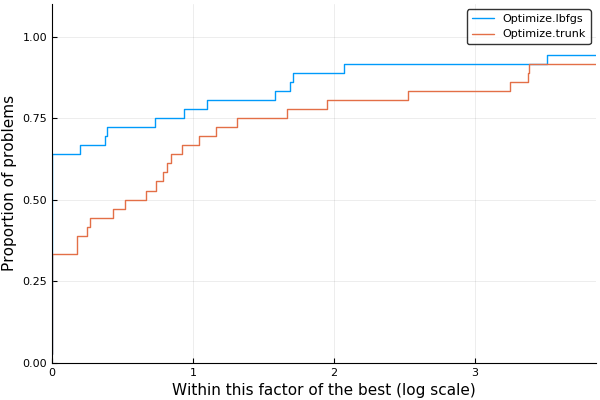

In [25]:
using BenchmarkProfiles

performance_profile(P, string.(mtds))

# Thank you

## Example solver

$$ \min\ f(x) \qquad \text{s. to} \qquad c(x) = 0. $$

Solve for $d_x$
$$ \left[\begin{array}{cc}
B_k & A_k^T \\ A_k & 0
\end{array}\right]
\left[\begin{array}{c}
d_x \\ d_{\lambda}
\end{array}\right]
=
- \left[\begin{array}{c}
g_k + A_k^T\lambda_k \\ c_k
\end{array}\right]$$

Line search on merit function $\varphi(x;\mu) = f(x) + \mu \Vert c(x)\Vert_1$
$$ \varphi(x + td_x; \mu) < \varphi(x; \mu) + \alpha t D\phi(x, d_x, \mu). $$

In [26]:
using Krylov

function sqp(nlp :: AbstractNLPModel; atol = 1e-4, rtol = 1e-6, ctol = 1e-6,
             max_iter = 10_000, max_f = 10_000, max_time = 60.0)
    if !equality_constrained(nlp)
        error("This solver is for equality constrained problems")
    elseif has_bounds(nlp)
        error("Can't handle bounds")
    end

    n, m = nlp.meta.nvar, nlp.meta.ncon
    
    x = nlp.meta.x0

    fx = obj(nlp, x)
    cx = cons(nlp, x)
    normcx = norm(cx, 1)

    ∇fx = grad(nlp, x)
    Jx = jac(nlp, x)

    λ = cgls(Jx', -∇fx)[1]
    ∇ℓx = ∇fx + Jx'*λ
    norm∇ℓx = norm(∇ℓx)
    
    Hxλ = hess(nlp, x, y=λ) + 1e-12 * speye(n, n)
    
    xt = copy(x)
    ct = copy(cx)
    
    Δ = max(0.1, min(100.0, 10norm∇ℓx))
    μ = 1.0
    
    iter = 0
    ϵ = atol + rtol * norm∇ℓx
    t₀ = time()
    Δt = 0.0
    
    solved = norm∇ℓx < ϵ && normcx < ctol
    tired = iter > max_iter || sum_counters(nlp) > max_f || Δt > max_time

    status = :unknown
    while !(solved || tired)
        W = Symmetric([Hxλ spzeros(n, m); Jx -1e-12*speye(m)], :L)
        F = ldltfact(Symmetric(W, :L))
        d = F \ [-∇ℓx; -cx]
        dx = d[1:n]
        dλ = d[n+1:end]
        
        gᵀd = dot(dx, ∇fx)
        if normcx > 0.0 && μ <= gᵀd / normcx
            μ = gᵀd / normcx + 1
        end
        ϕx = fx + μ * normcx # f(x) + μ ‖c(x)‖₁
        Dϕ = gᵀd - μ * normcx
        
        t = 1.0
        xt .= x + t * dx
        ft = obj(nlp, xt)
        ct .= cons(nlp, xt)
        normct = norm(ct, 1)
        ϕt = ft + μ * normct
        while !(ϕt < ϕx + 1e-2 * t * Dϕ)
            t /= 2.0
            if t < 1e-12
                status = :short_step
                break
            end
            xt .= x + t * dx
            ft = obj(nlp, xt)
            ct .= cons(nlp, xt)
            normct = norm(ct, 1)
            ϕt = ft + μ * normct
        end
        status != :unknown && break
        
        x .= xt
        fx = ft
        cx .= ct
        normcx = normct
        
        ∇fx = grad(nlp, x)
        Jx = jac(nlp, x)

        λ = cgls(Jx', -∇fx)[1]
        ∇ℓx = ∇fx + Jx'*λ
        norm∇ℓx = norm(∇ℓx)

        Hxλ = hess(nlp, x, y=λ) + 1e-12 * speye(n, n)
        
        iter += 1
        Δt = time() - t₀
        solved = norm∇ℓx < ϵ && normcx < ctol
        tired = iter > max_iter || sum_counters(nlp) > max_f || Δt > max_time
    end
    
    if solved
        status = :first_order
    elseif tired
        if iter > max_iter
            status = :max_iter
        elseif Δt > max_time
            status = :max_time
        else
            status = :max_evals
        end
    end

    return x, fx, norm∇ℓx, normcx, Δt, status
end

sqp (generic function with 1 method)

In [27]:
model = Model()
@variable(model, x[1:2], start=0.0)
@NLobjective(model, Min, (x[1] - 1.0)^2 + 100 * (x[2] - x[1]^2)^2)
@NLconstraint(model, x[1] + x[2] == 1.0)
nlp = MathProgNLPModel(model)
sqp(nlp)

([0.618796, 0.381204], 0.14560701802827003, 3.3635988397083165e-6, 3.1086244689504383e-15, 0.49768805503845215, :first_order)

In [28]:
using Ipopt

function ipopt(nlp :: AbstractNLPModel; kwargs...)
    model = NLPtoMPB(nlp, IpoptSolver(print_level=0))
    Δt = time()
    MathProgBase.optimize!(model)
    x = MathProgBase.getsolution(model)
    λ = MathProgBase.getconstrduals(model)
    gx = grad(nlp, x)
    dual = norm(gx + jtprod(nlp, x, λ))
    cx = cons(nlp, x)
    b = nlp.meta.lcon
    primal = norm(cx - b, 1)
    
    Δt = time() - Δt
    status = MathProgBase.status(model)

    return x, obj(nlp, x), dual, primal, Δt, status
end

ipopt (generic function with 1 method)

In [29]:
ipopt(nlp)

([0.618796, 0.381204], 0.1456070180282598, 0.96372276821365, 0.0, 0.07694506645202637, :Optimal)

In [30]:
problems = filter(x->contains(x, "HS") && length(x) <= 5,
            CUTEst.select(only_free_var=true, only_equ_con=true))
sort!(problems)
@printf("%-7s | %15s  %7s  %15s | %15s  %7s %15s\n",
        "Problem", "f(x)", "Δt", "status", "f(x)", "Δt", "status")
mtds = [sqp, ipopt]
for p in problems
    nlp = CUTEstModel(p)
    @printf("%-7s", p)
    for mtd in mtds
        try
            x, fx, nlx, ncx, Δt, status = mtd(nlp)
            @printf(" | %15.8e  %7.3f  %15s", fx, Δt, status)
        catch ex
            @printf(" | %15s  %7s  %15s\n", "-", "-", ex.msg)
        end
    end
    println("")
    finalize(nlp)
end

Problem |            f(x)       Δt           status |            f(x)       Δt          status
HS26    |  3.10249816e-12    0.001      first_order |  1.84236926e-16    0.036          Optimal
HS27    |  3.99999991e-02    0.001      first_order |  4.00000000e-02    0.001          Optimal
HS28    |  3.08148791e-33    0.000      first_order |  3.08148791e-33    0.000          Optimal
HS39    | -1.00000000e+00    0.001      first_order | -1.00000000e+00    0.000          Optimal
HS40    | -2.50000000e-01    0.000      first_order | -2.50000000e-01    0.000          Optimal
HS42    |  1.38578644e+01    0.000      first_order |  1.38578644e+01    0.000          Optimal
HS46    |  9.39073377e-12    0.001      first_order |  5.58198553e-16    0.002          Optimal
HS47    |  1.15830163e-10    0.001      first_order |  2.83573654e-14    0.001          Optimal
HS48    |  1.23259516e-32    0.000      first_order |  1.23259516e-32    0.000          Optimal
HS49    |  4.57324604e-06    0.000      f